In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
from data_loader import load_and_prepare_data
from evaluate import save_confusion_matrix, save_metrics
from model import get_tokenizer
from transformers import BertForSequenceClassification
import torch
import numpy as np
from pathlib import Path
from transformers import Trainer
from captum.attr import IntegratedGradients, LayerIntegratedGradients, visualization
from transformers import BertTokenizer, BertForSequenceClassification
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Image, HTML

### Reload Saved Model and Tokenizer

In [3]:
model_path = Path("..") / "outputs" / "model"

# Load trained model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = get_tokenizer().from_pretrained(model_path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Prepare Validation Data for Evaluation

In [5]:
# Reload test split and labels using same preprocessing logic as training
train_texts, test_texts, train_labels, test_labels, label_encoder = load_and_prepare_data()

# Tokenize test texts
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Wrap validation data in custom dataset class
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}

test_dataset = EmotionDataset(test_encodings, test_labels)

### Generate Predictions using the Hugging Face Trainer

In [7]:
# Initialize Hugging Face Trainer with the loaded model
trainer = Trainer(model=model)

# Generate raw predictions
predictions = trainer.predict(test_dataset)

# Extract labels and predicted classes
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

### Generate the Classification Report

In [9]:
from sklearn.metrics import classification_report

# Create and print the classification report
report = classification_report(
    y_true, 
    y_pred, 
    target_names=label_encoder.classes_,
    zero_division=0
)
print("Classification Report:\n")
print(report)

# Also save it as JSON
from sklearn.metrics import classification_report
import json
from pathlib import Path

metrics_dir = Path("..") / "outputs" / "metrics"
metrics_dir.mkdir(parents=True, exist_ok=True)

# Save the report in dictionary form for precision/recall/F1
report_dict = classification_report(
    y_true, 
    y_pred, 
    target_names=label_encoder.classes_, 
    output_dict=True,
    zero_division=0)

with open(metrics_dir / "report.json", "w") as f:
    json.dump(report_dict, f, indent=4)

Classification Report:

                precision    recall  f1-score   support

    admiration       0.67      0.76      0.71       542
     amusement       0.73      0.85      0.78       330
         anger       0.43      0.55      0.48       205
     annoyance       0.30      0.19      0.23       290
      approval       0.38      0.37      0.38       375
        caring       0.38      0.48      0.42       130
     confusion       0.50      0.42      0.46       172
     curiosity       0.46      0.60      0.52       278
        desire       0.64      0.53      0.58        78
disappointment       0.33      0.20      0.25       142
   disapproval       0.32      0.48      0.39       280
       disgust       0.51      0.45      0.48       100
 embarrassment       0.79      0.56      0.66        41
    excitement       0.42      0.31      0.36       102
          fear       0.81      0.50      0.62        86
     gratitude       0.91      0.88      0.90       371
         grief       0.

### Plot the Confusion Matrix

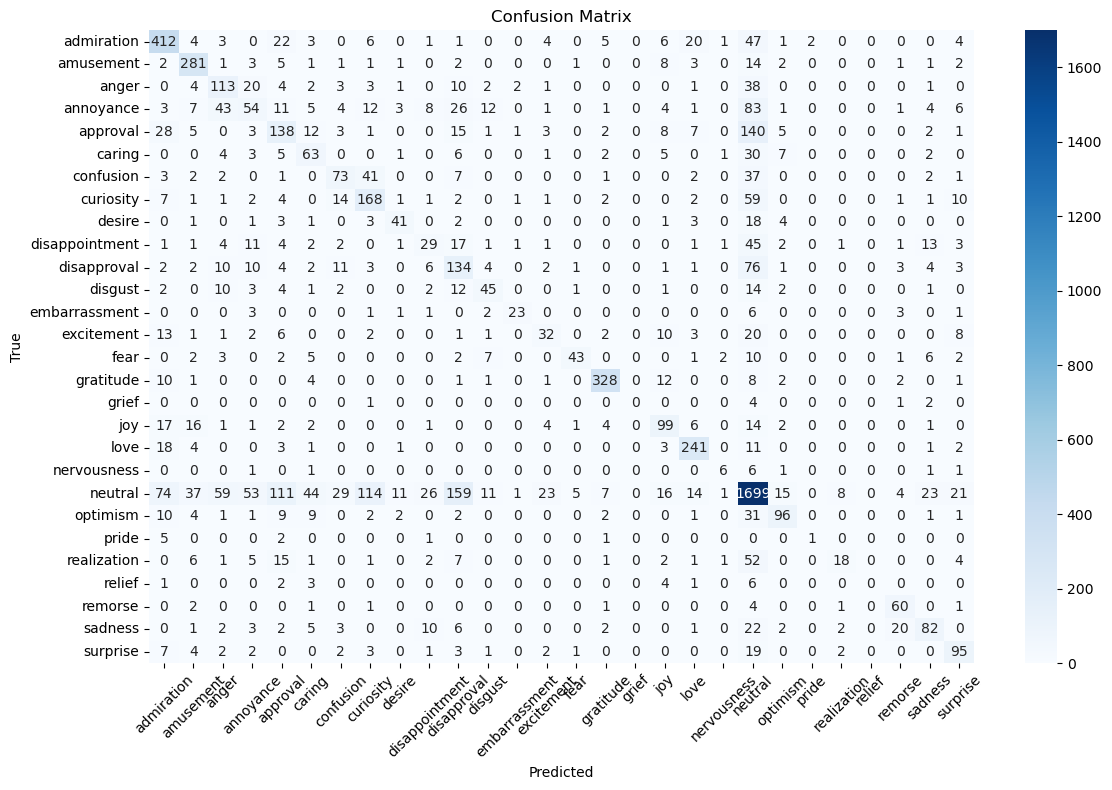

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(metrics_dir / "confusion_matrix.png")
plt.show()

## Interpretability with Captum

In this section, we apply the Integrated Gradients method from Captum to better understand how the model makes its predictions.  
We randomly select 5 validation samples, visualize token importance, and analyze how different words contribute to the model’s decision-making.

### Interpretation Summary

The above visualizations highlight which words in each text sample had the most influence on the model’s prediction.  
Larger importance values (darker colors or taller bars) indicate stronger contribution to the decision.  
This helps us verify whether the model is focusing on relevant keywords when classifying emotions.

In [14]:
# Define the custom forward function
def forward_func(inputs_embeds, attention_mask):
    outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
    return torch.softmax(outputs.logits, dim=1)

# Initialize Integrated Gradients
ig = IntegratedGradients(forward_func)

In [15]:
# Pick 5 random samples
sample_indices = random.sample(range(len(test_texts)), 5)
sample_texts = [test_texts[i] for i in sample_indices]
sample_labels = [test_labels[i] for i in sample_indices]

In [16]:
# Define helper functions for plotting
def plot_heatmap(tokens, attributions, label_name, idx):
    """
    Plots and saves a heatmap of token attributions.
    """
    attributions_np = attributions.detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(len(tokens) * 0.6, 2))
    ax.bar(range(len(tokens)), attributions_np, color='lightblue')
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha="right", fontsize=8)
    ax.set_title(f"Sample {idx+1} - True Label: {label_name}", fontsize=10)
    plt.tight_layout()
    plt.savefig(f"../outputs/interpretations/sample_{idx+1}_{label_name}_heatmap.png")
    plt.show()

def plot_bar(tokens, attributions, label_name, idx):
    """
    Plots and saves a horizontal bar chart of token attributions.
    """
    attributions_np = attributions.detach().cpu().numpy()
    tokens_np = np.array(tokens)
    fig, ax = plt.subplots(figsize=(6, len(tokens) * 0.4))
    ax.barh(tokens_np, attributions_np, color='salmon')
    ax.set_title(f"Attribution Scores (Bar) - Sample {idx+1}: {label_name}", fontsize=10)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"../outputs/interpretations/sample_{idx+1}_{label_name}_bar.png")
    plt.show()

In [17]:
device = torch.device("cpu")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

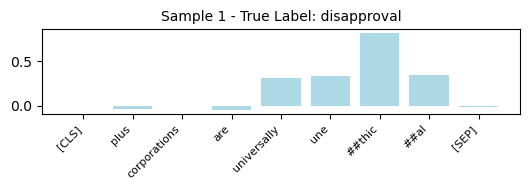

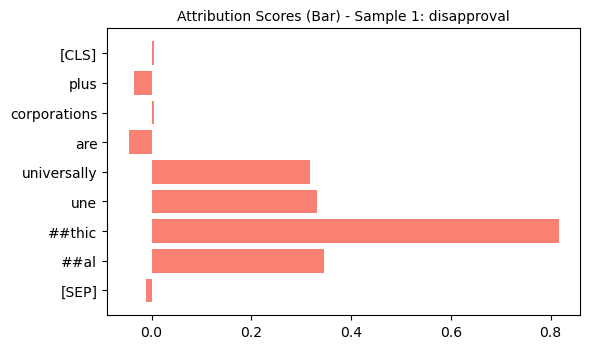

Saved interpretation plots for sample 1: 'disapproval'


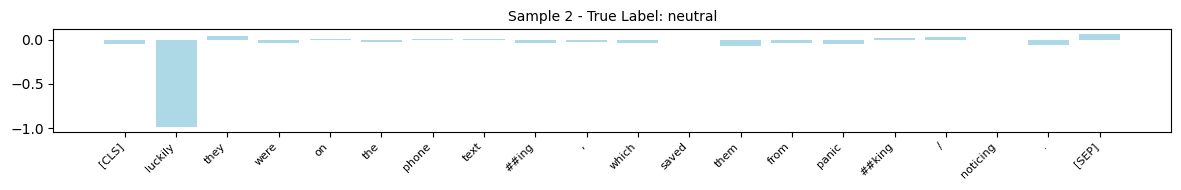

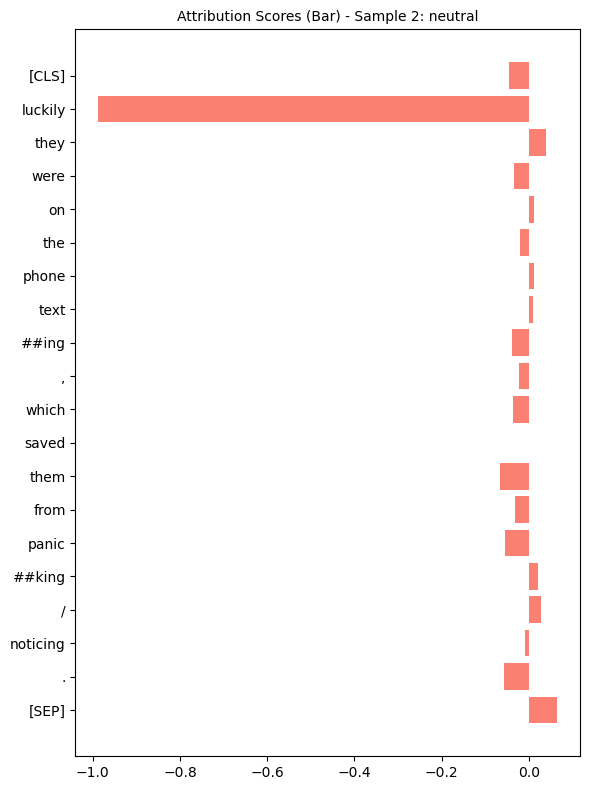

Saved interpretation plots for sample 2: 'neutral'


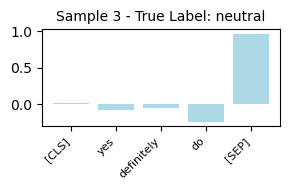

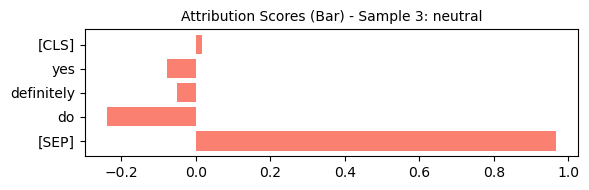

Saved interpretation plots for sample 3: 'neutral'


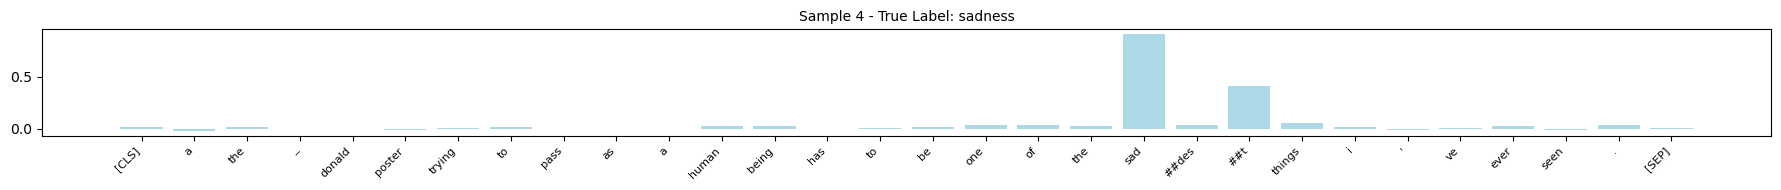

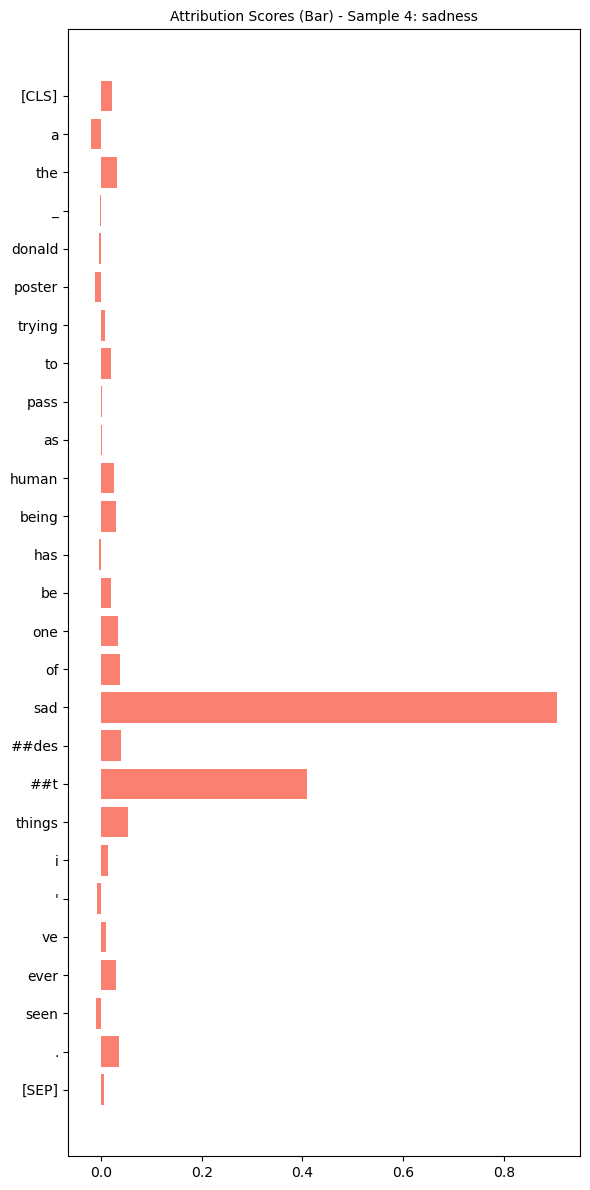

Saved interpretation plots for sample 4: 'sadness'


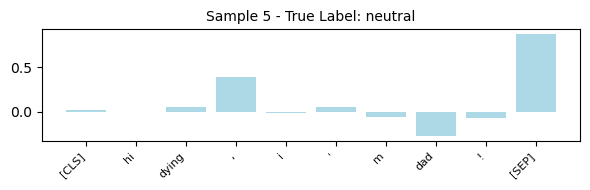

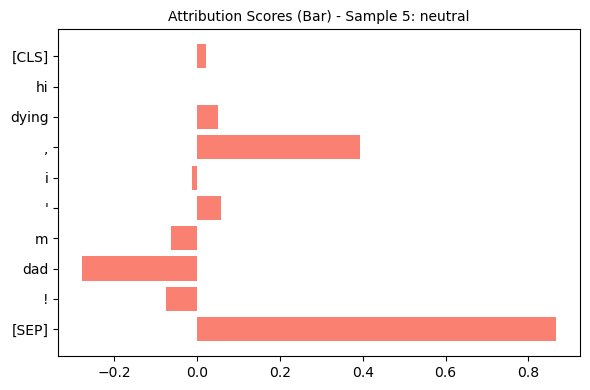

Saved interpretation plots for sample 5: 'neutral'


In [18]:
for idx, (text, label_idx) in enumerate(zip(sample_texts, sample_labels)):
    # Encode input
    encoded = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    input_ids = encoded['input_ids'].cpu().long()
    attention_mask = encoded['attention_mask'].cpu().long()

    # Get embeddings (input for IG)
    inputs_embeds = model.get_input_embeddings()(input_ids)

    # Compute attributions
    attributions, delta = ig.attribute(
        inputs=inputs_embeds,
        additional_forward_args=attention_mask,
        target=label_idx,
        return_convergence_delta=True
    )

    # Convert input_ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    # Mean across embedding dimension
    attributions_sum = attributions.sum(dim=-1).squeeze(0)
    attributions_sum = attributions_sum / torch.norm(attributions_sum)

    # Map label index to name
    label_name = label_encoder.inverse_transform([label_idx])[0]

    # Plot
    plot_heatmap(tokens, attributions_sum, label_name, idx)
    plot_bar(tokens, attributions_sum, label_name, idx)

    print(f"Saved interpretation plots for sample {idx+1}: '{label_name}'")


### Interpretation of Integrated Gradients Attributions

The Integrated Gradients plots (both heatmaps and bar charts) reveal how individual tokens contribute to the model’s classification of each emotion label. Below is an analysis of all five random samples:

Sample 1 – Disapproval
The tokens **##thic** and **##al** (from the word “unethical”) show the highest positive attribution toward the “disapproval” label. This indicates the model effectively identifies morally charged terms as central to the emotion. Tokens like “corporations” and “universally” also contribute, though to a lesser degree, suggesting the model picks up on critique of systemic entities.

Sample 2 – Neutral
Interestingly, the word “luckily” has a strong negative attribution, meaning it detracted from a more emotional label being assigned. Despite its connotation, the surrounding context likely flattened its impact. This reflects how nuanced sentiment-neutral language can shift overall classification.

Sample 3 – Neutral
The word “do” and the **[SEP]** token dominate the attribution, implying that minimal semantic content influenced the prediction. The model appears to correctly assign a neutral label to short, affirmative phrases like “yes definitely do,” focusing more on structure than emotional tone.

Sample 4 – Sadness
As expected, the word “sad” has the highest attribution, confirming the model’s reliance on explicit emotional language. Subword tokens like **##des** and “**##t**” also contribute meaningfully, which shows the tokenizer’s granularity doesn’t hinder attribution clarity. This attribution pattern demonstrates successful emotion recognition when keywords are present.

Sample 5 – Neutral
This example includes emotionally suggestive words like “dying” and “dad,” but the overall context lacks sufficient emotional framing. The model attributes some weight to punctuation and the **[SEP]** token, suggesting it interprets the message as incomplete or vague—supporting a neutral label.

